In [1]:
import numpy as np
import pandas as pd
import queue
import matplotlib.pyplot as plt

import sys
backtest_dir = 'C://backtest/backtest/'
if backtest_dir not in sys.path:
    sys.path.insert(0, backtest_dir)
    
from Backtest import *
from BayesianOptimization import *
from KDJStrategy import KDJStrategy
from Backtest.open_json_gz_files import open_json_gz_files
from Backtest.generate_bars import generate_bars

In [2]:
def run_backtest(config, trading_data, ohlc_data,
                 window = 10, sK=20, bK=80, delta = 10):
    window = int(window)
    sK = int(sK)
    sD = sK
    sJ = sK - delta
    bK = int(bK)
    bD = bK
    bJ = bK + delta
    config['title'] = "EMVStrategy" + "_" + str(window) + "_" + str(sK) + "_" + str(bK) + "_" + str(delta)
    print("---------------------------------")
    print(config['title'])
    print("---------------------------------")
    
    events_queue = queue.Queue()

    data_handler = OHLCDataHandler(
        config, events_queue,
        trading_data = trading_data, ohlc_data = ohlc_data
    )
    strategy = KDJStrategy(config, events_queue, data_handler,
                         window = window, sK=sK, sD=sD, sJ=sJ, bK=bK, bD=bD, bJ=bJ)

    backtest = Backtest(config, events_queue, strategy,
                        data_handler= data_handler)

    results = backtest.start_trading()
    
    # dict_ans = {
    #     "window": [window],
    #     "sK/sD/sJ": [(sK, sD, sJ)],
    #     "bK/bD/bJ": [(bK, bD, bJ)],
    #     "Sharpe Ratio": [results['sharpe']],
    #     "Total Returns": [(results['cum_returns'][-1] - 1)],
    #     "Max Drawdown": [(results["max_drawdown"] * 100.0)],
    #     "Max Drawdown Duration": [(results['max_drawdown_duration'])],
    #     "Trades": [results['trade_info']['trading_num']],
    #     "Trade Winning": [results['trade_info']['win_pct']],
    #     "Average Trade": [results['trade_info']['avg_trd_pct']],
    #     "Average Win": [results['trade_info']['avg_win_pct']],
    #     "Average Loss": [results['trade_info']['avg_loss_pct']],
    #     "Best Trade": [results['trade_info']['max_win_pct']],
    #     "Worst Trade": [results['trade_info']['max_loss_pct']],
    #     "Worst Trade Date": [results['trade_info']['max_loss_dt']],
    #     "Avg Days in Trade": [results['trade_info']['avg_dit']]
    # }
    # return pd.DataFrame(dict_ans)
    return (results['cum_returns'][-1] - 1)

## Setting

In [3]:
config = {
    "csv_dir": "C:/backtest/Binance",
    "out_dir": "C:/backtest/results/KDJStrategy",
    "title": "KDJStrategy",
    "is_plot": False,
    "save_plot": False,
    "save_tradelog": False,
    "start_date": pd.Timestamp("2017-07-01T00:0:00", freq = "60" + "T"),    # str(freq) + "T"
    "end_date": pd.Timestamp("2018-04-01T00:00:00", freq = "60" + "T"),
    "equity": 1.0,
    "freq": 60,      # min
    "commission_ratio": 0.001,
    "suggested_quantity": None,     # None or a value
    "max_quantity": None,           # None or a value, Maximum purchase quantity
    "min_quantity": None,           # None or a value, Minimum purchase quantity
    "min_handheld_cash": None,      # None or a value, Minimum handheld funds
    "exchange": "Binance",
    "tickers": ['BTCUSDT']
}

In [4]:
# trading_data = {}
# for ticker in config['tickers']:
#     # trading_data[ticker] = open_gz_files(config['csv_dir'], ticker)
#     trading_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker + '.h5', key=ticker)

ohlc_data = {}
for ticker in config['tickers']:
    # ohlc_data[ticker] = generate_bars(trading_data, ticker, config['freq'])
    ohlc_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker +'_OHLC_60min.h5', key=ticker)

trading_data = None

In [5]:
gp_params = {"alpha": 1e-5}

## Acquisition Function "Upper Confidence Bound"

* Prefer exploitation (kappa=1.0)

* Prefer exploration (kappa=10)


## Acquisition Function "Expected Improvement"

* Prefer exploitation (xi=1e-4)
* Prefer exploration (xi=0.1)

In [13]:
BO = BayesianOptimization(
    run_backtest,
    pbounds = {'window': (1, 120),
              'sK': (10, 30),
              'bK': (70, 90),
              'delta': (-20, 20)},
    is_int = [1, 1, 1, 1], 
    invariant = {
        'config': config,
        'trading_data': trading_data,
        'ohlc_data': ohlc_data
    },
    random_state = 1
)
# BO.explore({
#     'window': np.arange(1, 120, 12),
#     'sK': np.arange(10, 30, 2),
#     'bK': np.arange(90, 70, -1),
#     'delta': np.repeat(10, 10)
#     },
#     eager=True)
BO.maximize(init_points=50, n_iter=100, acq="ei", xi=0.01, **gp_params)

Initialization
-----------------------------------------------------------------------------
 Step |   Time |      Value |        bK |     delta |        sK |    window | 
---------------------------------
EMVStrategy_38_29_76_13.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.9759031245
Max Drawdown: 49.9854269442
Max Drawdown Duration: 2510
Total Returns: 0.4133201571
---------------------------------
Trades: 27
Trade Winning: 44%
Average Trade: 2.21%
Average Win: 12.99%
Average Loss: -6.42%
Best Trade: 36.37%
Worst Trade: -16.67%
Worst Trade Date: 0 days 21:00:00
Avg Days in Trade: 3 days 07:15:33
---------------------------------
    1 | 00m04s |    0.41332 | 76.000000 | 13.000000 | 29.000000 | 38.000000 | 
--

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.4676666565
Max Drawdown: 65.7173916835
Max Drawdown Duration: 2510
Total Returns: 0.0366940531
---------------------------------
Trades: 31
Trade Winning: 39%
Average Trade: 1.46%
Average Win: 13.68%
Average Loss: -6.26%
Best Trade: 74.91%
Worst Trade: -27.44%
Worst Trade Date: 4 days 18:00:00
Avg Days in Trade: 3 days 07:40:39
---------------------------------
   11 | 00m01s |    0.03669 | 74.000000 | -6.000000 | 27.000000 | 2.000000 | 
---------------------------------
EMVStrategy_77_21_77_-7.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.9493752159
Max Drawdown: 61.3346664705
Max Drawdown Duration: 2736
Total

---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.4635645740
Max Drawdown: 68.7599108553
Max Drawdown Duration: 2510
Total Returns: 0.0596395350
---------------------------------
Trades: 10
Trade Winning: 40%
Average Trade: 5.80%
Average Win: 36.23%
Average Loss: -14.48%
Best Trade: 114.42%
Worst Trade: -30.13%
Worst Trade Date: 13 days 14:00:00
Avg Days in Trade: 10 days 04:42:00
---------------------------------
   21 | 00m12s |    0.05964 | 87.000000 | -15.000000 | 14.000000 | 85.000000 | 
---------------------------------
EMVStrategy_12_25_77_16.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
----------------------------

---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.0462922300
Max Drawdown: 56.4094830062
Max Drawdown Duration: 2510
Total Returns: 0.4547585026
---------------------------------
Trades: 13
Trade Winning: 46%
Average Trade: 5.11%
Average Win: 24.09%
Average Loss: -11.16%
Best Trade: 54.90%
Worst Trade: -17.21%
Worst Trade Date: 2 days 06:00:00
Avg Days in Trade: 7 days 01:09:14
---------------------------------
   31 | 00m15s |    0.45476 | 72.000000 | 8.000000 | 29.000000 | 106.000000 | 
---------------------------------
EMVStrategy_114_16_82_-17.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
------------------------------

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.7964974263
Max Drawdown: 56.3356628616
Max Drawdown Duration: 2736
Total Returns: 0.2784770164
---------------------------------
Trades: 16
Trade Winning: 44%
Average Trade: 3.14%
Average Win: 18.99%
Average Loss: -9.20%
Best Trade: 51.57%
Worst Trade: -23.12%
Worst Trade Date: 2 days 22:00:00
Avg Days in Trade: 5 days 19:41:15
---------------------------------
   41 | 00m09s |    0.27848 | 77.000000 | -18.000000 | 20.000000 | 62.000000 | 
---------------------------------
EMVStrategy_23_24_77_0.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.3456893695
Max Drawdown: 46.8921019008
Max Drawdown Duration: 2510
Tota

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.5702394836
Max Drawdown: 60.8512851075
Max Drawdown Duration: 2736
Total Returns: 0.1342390635
---------------------------------
Trades: 12
Trade Winning: 42%
Average Trade: 2.46%
Average Win: 19.31%
Average Loss: -9.58%
Best Trade: 33.99%
Worst Trade: -17.93%
Worst Trade Date: 2 days 05:00:00
Avg Days in Trade: 6 days 15:25:00
---------------------------------
   51 | 00m25s |    0.13424 | 84.000000 | -16.000000 | 30.000000 | 98.000000 | 
---------------------------------
EMVStrategy_84_30_70_20.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.1365870489
Max Drawdown: 48.4772778933
Max Drawdown Duration: 2736
Tot

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.0079198486
Max Drawdown: 66.3452976207
Max Drawdown Duration: 2510
Total Returns: 0.4285998547
---------------------------------
Trades: 9
Trade Winning: 44%
Average Trade: 9.22%
Average Win: 37.50%
Average Loss: -13.40%
Best Trade: 109.88%
Worst Trade: -19.85%
Worst Trade Date: 1 days 23:00:00
Avg Days in Trade: 10 days 06:46:40
---------------------------------
   61 | 00m35s |    0.42860 | 88.000000 | -19.000000 | 21.000000 | 104.000000 | 
---------------------------------
EMVStrategy_30_30_90_20.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.3267807326
Max Drawdown: 46.1712464490
Max Drawdown Duration: 2736


---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.5931557863
Max Drawdown: 50.6680393398
Max Drawdown Duration: 2510
Total Returns: 0.9016687263
---------------------------------
Trades: 10
Trade Winning: 50%
Average Trade: 8.82%
Average Win: 26.72%
Average Loss: -9.08%
Best Trade: 50.49%
Worst Trade: -15.68%
Worst Trade Date: 2 days 04:00:00
Avg Days in Trade: 8 days 04:48:00
---------------------------------
   71 | 00m35s |    0.90167 | 83.000000 | -20.000000 | 27.000000 | 103.000000 | 
---------------------------------
EMVStrategy_8_17_70_-20.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: -0.0091454206
Max Drawdown: 75.7582189907
Max Drawdown Duration: 2510
T

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.4118996474
Max Drawdown: 72.3448387474
Max Drawdown Duration: 2510
Total Returns: 0.0112969351
---------------------------------
Trades: 8
Trade Winning: 38%
Average Trade: 4.88%
Average Win: 37.68%
Average Loss: -14.81%
Best Trade: 85.49%
Worst Trade: -31.79%
Worst Trade Date: 14 days 02:00:00
Avg Days in Trade: 13 days 09:30:00
---------------------------------
   81 | 00m38s |    0.01130 | 70.000000 | -1.000000 | 10.000000 | 120.000000 | 
---------------------------------
EMVStrategy_94_10_70_20.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.7349189292
Max Drawdown: 63.0049019401
Max Drawdown Duration: 2510
T

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.6438345100
Max Drawdown: 67.8224154774
Max Drawdown Duration: 2510
Total Returns: 0.1478428258
---------------------------------
Trades: 2
Trade Winning: 100%
Average Trade: 15.60%
Average Win: 15.60%
Average Loss: nan%
Best Trade: 23.17%
Worst Trade: 8.02%
Worst Trade Date: 48 days 05:00:00
Avg Days in Trade: 73 days 20:30:00
---------------------------------
   91 | 00m26s |    0.14784 | 70.000000 | 20.000000 | 10.000000 | 17.000000 | 
---------------------------------
EMVStrategy_105_10_70_9.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.6308932865
Max Drawdown: 66.5708933867
Max Drawdown Duration: 2510
Total

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.4770670528
Max Drawdown: 50.7856756916
Max Drawdown Duration: 2736
Total Returns: 0.0927761661
---------------------------------
Trades: 14
Trade Winning: 50%
Average Trade: 1.53%
Average Win: 11.53%
Average Loss: -8.47%
Best Trade: 27.98%
Worst Trade: -14.48%
Worst Trade Date: 1 days 15:00:00
Avg Days in Trade: 4 days 14:34:17
---------------------------------
  101 | 00m33s |    0.09278 | 90.000000 | 20.000000 | 30.000000 | 58.000000 | 
---------------------------------
EMVStrategy_54_30_70_-20.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.0464927605
Max Drawdown: 43.7148268804
Max Drawdown Duration: 2510
Tot

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.2099240944
Max Drawdown: 59.1722184661
Max Drawdown Duration: 2736
Total Returns: -0.0400268342
---------------------------------
Trades: 12
Trade Winning: 50%
Average Trade: 0.84%
Average Win: 12.70%
Average Loss: -11.03%
Best Trade: 33.23%
Worst Trade: -16.62%
Worst Trade Date: 1 days 20:00:00
Avg Days in Trade: 5 days 12:00:00
---------------------------------
  111 | 00m33s |   -0.04003 | 90.000000 | 20.000000 | 30.000000 | 78.000000 | 
---------------------------------
EMVStrategy_31_10_70_-20.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.8521221267
Max Drawdown: 59.7671160189
Max Drawdown Duration: 2510
T

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.9183169735
Max Drawdown: 62.2152335948
Max Drawdown Duration: 2510
Total Returns: 0.3722807873
---------------------------------
Trades: 12
Trade Winning: 33%
Average Trade: 6.96%
Average Win: 37.85%
Average Loss: -8.48%
Best Trade: 121.79%
Worst Trade: -24.97%
Worst Trade Date: 2 days 20:00:00
Avg Days in Trade: 7 days 17:00:00
---------------------------------
  121 | 00m31s |    0.37228 | 81.000000 | -8.000000 | 18.000000 | 72.000000 | 
---------------------------------
EMVStrategy_17_26_82_-1.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.9188997600
Max Drawdown: 47.7959636280
Max Drawdown Duration: 2510
Tot

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.6663541313
Max Drawdown: 46.4796487688
Max Drawdown Duration: 2510
Total Returns: 0.1894832228
---------------------------------
Trades: 17
Trade Winning: 35%
Average Trade: 1.91%
Average Win: 15.76%
Average Loss: -5.65%
Best Trade: 30.79%
Worst Trade: -10.77%
Worst Trade Date: 1 days 23:00:00
Avg Days in Trade: 4 days 02:07:04
---------------------------------
  131 | 00m27s |    0.18948 | 90.000000 | -10.000000 | 30.000000 | 55.000000 | 
---------------------------------
EMVStrategy_49_30_70_-7.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.1894548742
Max Drawdown: 43.2985670542
Max Drawdown Duration: 2510
Tot

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.3026000404
Max Drawdown: 69.7143441199
Max Drawdown Duration: 2510
Total Returns: -0.0475283581
---------------------------------
Trades: 18
Trade Winning: 39%
Average Trade: 2.16%
Average Win: 20.20%
Average Loss: -9.32%
Best Trade: 95.11%
Worst Trade: -28.56%
Worst Trade Date: 5 days 21:00:00
Avg Days in Trade: 5 days 17:13:20
---------------------------------
  141 | 00m21s |   -0.04753 | 85.000000 | -12.000000 | 16.000000 | 19.000000 | 
---------------------------------
EMVStrategy_90_11_87_-2.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.1456677162
Max Drawdown: 71.7939644631
Max Drawdown Duration: 2510
To

In [14]:
print(BO.res['max'])

{'max_val': 1.327369266849236, 'max_params': {'window': 21.0, 'sK': 28.0, 'bK': 70.0, 'delta': -11.0}}


In [15]:
BO.maximize(init_points=0, n_iter=100, acq="ei", xi=0.0001, **gp_params)

Bayesian Optimization
-----------------------------------------------------------------------------
 Step |   Time |      Value |        bK |     delta |        sK |    window | 
---------------------------------
EMVStrategy_16_13_79_-2.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.7123101462
Max Drawdown: 62.2213119736
Max Drawdown Duration: 2510
Total Returns: 0.2076809356
---------------------------------
Trades: 13
Trade Winning: 54%
Average Trade: 2.87%
Average Win: 12.49%
Average Loss: -8.35%
Best Trade: 58.45%
Worst Trade: -11.36%
Worst Trade Date: 12 days 15:00:00
Avg Days in Trade: 9 days 21:23:05
---------------------------------
  151 | 00m28s |    0.20768 | 79.000000 | -2.000000 | 13.000000 | 16.0000

---------------------------------
EMVStrategy_73_21_75_7.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.8302749665
Max Drawdown: 59.6760306524
Max Drawdown Duration: 2736
Total Returns: 0.3040250628
---------------------------------
Trades: 14
Trade Winning: 29%
Average Trade: 4.44%
Average Win: 33.38%
Average Loss: -7.14%
Best Trade: 91.30%
Worst Trade: -12.68%
Worst Trade Date: 2 days 23:00:00
Avg Days in Trade: 6 days 15:04:17
---------------------------------
  161 | 00m24s |    0.30403 | 75.000000 | 7.000000 | 21.000000 | 73.000000 | 
---------------------------------
EMVStrategy_4_23_76_-16.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018

---------------------------------
EMVStrategy_23_25_77_-20.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.4479893277
Max Drawdown: 45.0970202469
Max Drawdown Duration: 2510
Total Returns: 0.8388387549
---------------------------------
Trades: 29
Trade Winning: 48%
Average Trade: 3.48%
Average Win: 13.82%
Average Loss: -6.17%
Best Trade: 73.98%
Worst Trade: -12.00%
Worst Trade Date: 1 days 08:00:00
Avg Days in Trade: 3 days 07:22:46
---------------------------------
  171 | 00m22s |    0.83884 | 77.000000 | -20.000000 | 25.000000 | 23.000000 | 
---------------------------------
EMVStrategy_85_26_80_0.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2

C:\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.02474074e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


---------------------------------
EMVStrategy_120_30_90_-7.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.2783605106
Max Drawdown: 52.0334783681
Max Drawdown Duration: 2510
Total Returns: 0.5836056897
---------------------------------
Trades: 9
Trade Winning: 56%
Average Trade: 7.41%
Average Win: 22.71%
Average Loss: -11.71%
Best Trade: 50.33%
Worst Trade: -16.41%
Worst Trade Date: 3 days 04:00:00
Avg Days in Trade: 8 days 03:46:40
---------------------------------
  180 | 00m32s |    0.58361 | 90.000000 | -7.000000 | 30.000000 | 120.000000 | 
---------------------------------
EMVStrategy_77_17_83_13.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 

---------------------------------
EMVStrategy_62_10_90_8.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.9381755076
Max Drawdown: 56.6527451241
Max Drawdown Duration: 2510
Total Returns: 0.3963516639
---------------------------------
Trades: 7
Trade Winning: 57%
Average Trade: 7.10%
Average Win: 20.43%
Average Loss: -10.66%
Best Trade: 52.47%
Worst Trade: -15.36%
Worst Trade Date: 2 days 06:00:00
Avg Days in Trade: 16 days 11:34:17
---------------------------------
  190 | 00m21s |    0.39635 | 90.000000 | 8.000000 | 10.000000 | 62.000000 | 
---------------------------------
EMVStrategy_58_30_80_6.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018

---------------------------------
EMVStrategy_77_21_79_-10.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.8879624345
Max Drawdown: 62.5020886964
Max Drawdown Duration: 2736
Total Returns: 0.3425585817
---------------------------------
Trades: 13
Trade Winning: 31%
Average Trade: 5.03%
Average Win: 33.35%
Average Loss: -7.56%
Best Trade: 91.62%
Worst Trade: -15.01%
Worst Trade Date: 2 days 18:00:00
Avg Days in Trade: 6 days 21:13:51
---------------------------------
  200 | 00m18s |    0.34256 | 79.000000 | -10.000000 | 21.000000 | 77.000000 | 
---------------------------------
EMVStrategy_80_30_70_-12.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	:

---------------------------------
EMVStrategy_32_20_79_-20.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.9798736283
Max Drawdown: 58.5837471134
Max Drawdown Duration: 2510
Total Returns: 0.4291419861
---------------------------------
Trades: 21
Trade Winning: 38%
Average Trade: 4.39%
Average Win: 23.97%
Average Loss: -7.66%
Best Trade: 118.22%
Worst Trade: -22.62%
Worst Trade Date: 0 days 20:00:00
Avg Days in Trade: 4 days 19:17:09
---------------------------------
  210 | 00m14s |    0.42914 | 79.000000 | -20.000000 | 20.000000 | 32.000000 | 
---------------------------------
EMVStrategy_103_22_73_-16.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date

---------------------------------
EMVStrategy_84_19_87_-13.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.2666086925
Max Drawdown: 58.5127855585
Max Drawdown Duration: 2510
Total Returns: 0.6343992263
---------------------------------
Trades: 10
Trade Winning: 40%
Average Trade: 10.16%
Average Win: 40.85%
Average Loss: -10.31%
Best Trade: 122.97%
Worst Trade: -16.29%
Worst Trade Date: 2 days 11:00:00
Avg Days in Trade: 8 days 12:06:00
---------------------------------
  220 | 00m15s |    0.63440 | 87.000000 | -13.000000 | 19.000000 | 84.000000 | 


C:\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.40765038e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


---------------------------------
EMVStrategy_81_10_70_-14.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.1326776902
Max Drawdown: 57.3679307514
Max Drawdown Duration: 2510
Total Returns: 0.5811091267
---------------------------------
Trades: 8
Trade Winning: 50%
Average Trade: 10.38%
Average Win: 32.33%
Average Loss: -11.56%
Best Trade: 94.98%
Worst Trade: -25.50%
Worst Trade Date: 14 days 09:00:00
Avg Days in Trade: 14 days 18:00:00
---------------------------------
  221 | 00m17s |    0.58111 | 70.000000 | -14.000000 | 10.000000 | 81.000000 | 
---------------------------------
EMVStrategy_24_30_74_12.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date

---------------------------------
EMVStrategy_67_21_78_15.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.8894699160
Max Drawdown: 56.1595890197
Max Drawdown Duration: 2736
Total Returns: 0.3458889482
---------------------------------
Trades: 14
Trade Winning: 36%
Average Trade: 4.81%
Average Win: 29.10%
Average Loss: -8.69%
Best Trade: 91.62%
Worst Trade: -15.01%
Worst Trade Date: 2 days 18:00:00
Avg Days in Trade: 6 days 14:04:17
---------------------------------
  231 | 00m24s |    0.34589 | 78.000000 | 15.000000 | 21.000000 | 67.000000 | 
---------------------------------
EMVStrategy_44_10_87_0.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 201

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.3212914357
Max Drawdown: 47.2117491873
Max Drawdown Duration: 2736
Total Returns: 0.6617682816
---------------------------------
Trades: 12
Trade Winning: 58%
Average Trade: 5.56%
Average Win: 14.94%
Average Loss: -7.57%
Best Trade: 39.60%
Worst Trade: -12.39%
Worst Trade Date: 2 days 12:00:00
Avg Days in Trade: 6 days 15:45:00
---------------------------------
  241 | 00m54s |    0.66177 | 82.000000 | -1.000000 | 26.000000 | 85.000000 | 
---------------------------------
EMVStrategy_25_20_70_19.0
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.8581723563
Max Drawdown: 59.8393814238
Max Drawdown Duration: 2510
Tota

In [16]:
print(BO.res['max'])

{'max_val': 1.4033972222055136, 'max_params': {'window': 25.0, 'sK': 30.0, 'bK': 72.0, 'delta': 17.0}}


In [17]:
Target = pd.DataFrame({'Parameters': BO.X.tolist(), 'Target': BO.Y})
# Target.to_csv(config['out_dir'] + "/target_ei.csv")
Target.sort_values(by = "Target")

,Parameters,Target
65,"[12.0, 15.0, 86.0, 4.0]",-0.500845
96,"[10.0, 17.0, 83.0, 17.0]",-0.426717
167,"[8.0, 21.0, 86.0, -5.0]",-0.358405
4,"[10.0, 17.0, 77.0, 5.0]",-0.290401
71,"[8.0, 17.0, 70.0, -20.0]",-0.271265
147,"[1.0, 30.0, 90.0, 8.0]",-0.257039
85,"[1.0, 30.0, 90.0, -20.0]",-0.257039
223,"[14.0, 18.0, 83.0, 16.0]",-0.237032
222,"[12.0, 17.0, 75.0, 12.0]",-0.205550
224,"[10.0, 24.0, 86.0, -9.0]",-0.179182


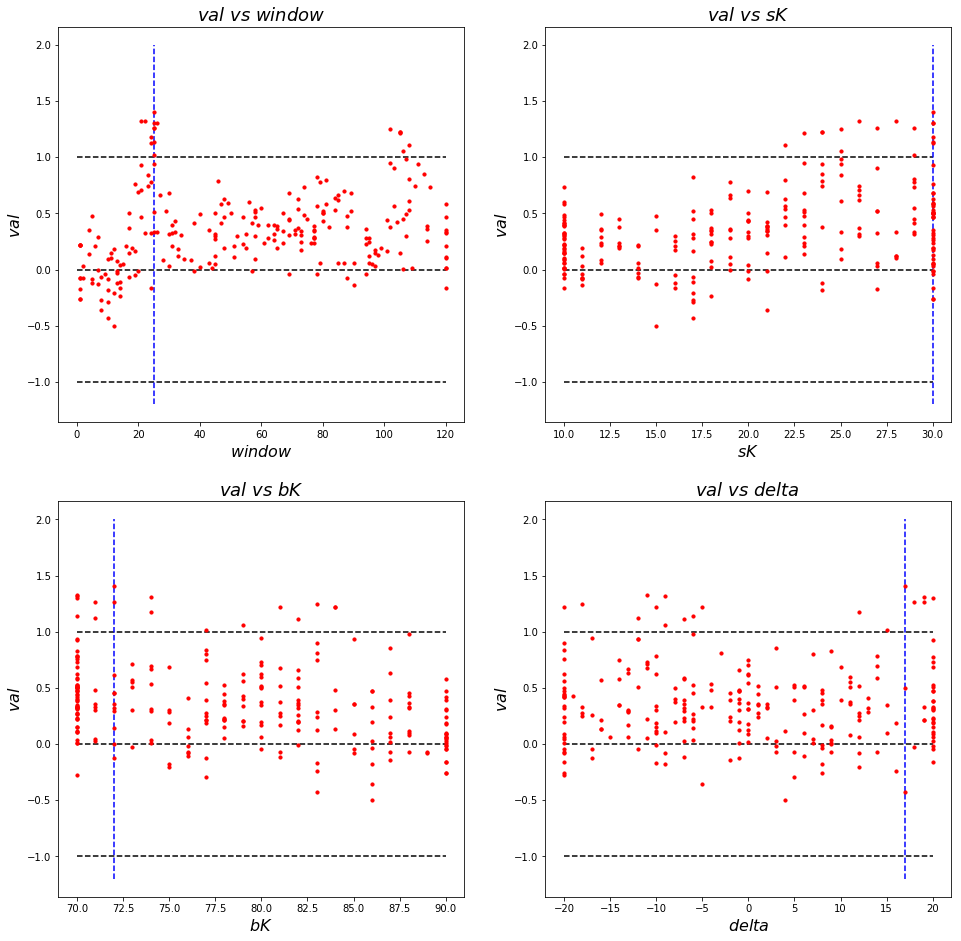

In [18]:
f, ax = plt.subplots(2,2, figsize = (16, 16))
ax[0,0].scatter(BO.X[:,0].flatten(), BO.Y, c="red", s=10, zorder=10)
ax[0,0].set_title('$val$ $vs$ $window$ ', fontsize=18)
ax[0,0].set_xlabel('$window$', fontsize=16)
ax[0,0].set_ylabel('$val$', fontsize=16)
ax[0,0].hlines(0, 0, 120, color='black',linestyle="--")
ax[0,0].hlines(-1, 0, 120, color='black',linestyle="--")
ax[0,0].hlines(1, 0, 120, color='black',linestyle="--")
ax[0,0].vlines(BO.res['max']['max_params']['window'], -1.2, 2, color='blue',linestyle="--")

ax[0,1].scatter(BO.X[:,1].flatten(), BO.Y, c="red", s=10, zorder=10)
ax[0,1].set_title('$val$ $vs$ $sK$ ', fontsize=18)
ax[0,1].set_xlabel('$sK$', fontsize=16)
ax[0,1].set_ylabel('$val$', fontsize=16)
ax[0,1].hlines(0, 10, 30,color='black',linestyle="--")
ax[0,1].hlines(-1, 10, 30, color='black',linestyle="--")
ax[0,1].hlines(1, 10, 30,color='black',linestyle="--")
ax[0,1].vlines(BO.res['max']['max_params']['sK'], -1.2, 2, color='blue',linestyle="--")

ax[1,0].scatter(BO.X[:,2].flatten(), BO.Y, c="red", s=10, zorder=10)
ax[1,0].set_title('$val$ $vs$ $bK$ ', fontsize=18)
ax[1,0].set_xlabel('$bK$', fontsize=16)
ax[1,0].set_ylabel('$val$', fontsize=16)
ax[1,0].hlines(0, 70, 90,color='black',linestyle="--")
ax[1,0].hlines(-1, 70, 90, color='black',linestyle="--")
ax[1,0].hlines(1, 70, 90,color='black',linestyle="--")
ax[1,0].vlines(BO.res['max']['max_params']['bK'], -1.2, 2, color='blue',linestyle="--")

ax[1,1].scatter(BO.X[:,3].flatten(), BO.Y, c="red", s=10, zorder=10)
ax[1,1].set_title('$val$ $vs$ $delta$ ', fontsize=18)
ax[1,1].set_xlabel('$delta$', fontsize=16)
ax[1,1].set_ylabel('$val$', fontsize=16)
ax[1,1].hlines(0, -20, 20,color='black',linestyle="--")
ax[1,1].hlines(-1, -20, 20, color='black',linestyle="--")
ax[1,1].hlines(1, -20, 20,color='black',linestyle="--")
ax[1,1].vlines(BO.res['max']['max_params']['delta'], -1.2, 2, color='blue',linestyle="--")

## Acquisition Function "Probability of Improvement"

* Prefer exploitation (xi=1e-4)
* Prefer exploration (xi=0.1)